# Ví dụ 1.  
(Dữ liệu tự tạo)

## Cách 1. Build from scratch  

### Xây dựng các hàm kernel khác nhau (linear, poly, gaussian, rbf)  

In [1]:
import numpy as np
from numpy import linalg

from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

import cvxopt
import cvxopt.solvers


def linear_kernel(x1, x2):
    return np.dot(x1, x2)


def polynomial_kernel(x, y, gamma=1, r=1, d=3):
    return (r + gamma * np.dot(x, y)) ** d


def gaussian_kernel(x, y, sigma=5.0):
    # gamma = 1.0/(2 * (sigma ** 2))
    return np.exp(-linalg.norm(x - y) ** 2 / (2 * (sigma**2)))

### Xây dựng lớp SVM 

In [2]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None:
            self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Solve Quadratic Programming problem
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers a = \lambda
        a = np.ravel(solution["x"])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

## Tạo dữ liệu và trực quan hóa SVM đã xây dựng

In [3]:
import pylab as pl


def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0, 0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train


def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test


def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    if clf.w is not None:
        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()


def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train == 1], X_train[y_train == -1], clf)


def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(kernel=gaussian_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train == 1], X_train[y_train == -1], clf)


def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train == 1], X_train[y_train == -1], clf)

In [4]:
# if __name__ == "__main__":
    # test_linear()
    # test_non_linear()
    # test_soft()

     pcost       dcost       gap    pres   dres
 0: -1.6656e+01 -2.9081e+01  5e+02  2e+01  2e+00
 1: -1.6605e+01 -5.0778e+00  5e+01  2e+00  2e-01
 2: -2.4725e+00 -2.1929e+00  2e+00  9e-02  7e-03
 3: -2.0252e+00 -2.0032e+00  4e-01  2e-02  1e-03
 4: -1.9284e+00 -1.9903e+00  1e-01  2e-03  1e-04
 5: -1.9767e+00 -1.9848e+00  1e-02  2e-04  2e-05
 6: -1.9838e+00 -1.9845e+00  9e-04  1e-05  8e-07
 7: -1.9844e+00 -1.9844e+00  9e-06  1e-07  8e-09
 8: -1.9844e+00 -1.9844e+00  9e-08  1e-09  8e-11
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


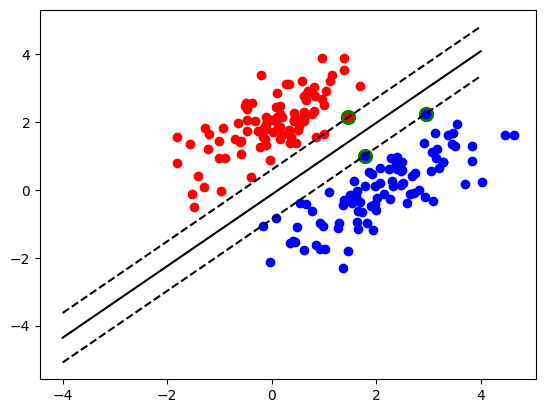

In [5]:
test_linear()

     pcost       dcost       gap    pres   dres
 0: -5.7502e+01 -1.6922e+02  5e+02  2e+01  2e+00
 1: -9.3644e+01 -2.1951e+02  2e+02  8e+00  1e+00
 2: -1.4216e+02 -2.7412e+02  2e+02  5e+00  6e-01
 3: -1.7147e+02 -2.5623e+02  1e+02  2e+00  3e-01
 4: -1.8017e+02 -2.6588e+02  1e+02  2e+00  3e-01
 5: -2.2079e+02 -2.9509e+02  1e+02  1e+00  2e-01
 6: -2.5071e+02 -2.7072e+02  2e+01  9e-02  1e-02
 7: -2.5984e+02 -2.6549e+02  6e+00  2e-03  3e-04
 8: -2.6446e+02 -2.6470e+02  2e-01  9e-05  1e-05
 9: -2.6467e+02 -2.6467e+02  2e-03  9e-07  1e-07
10: -2.6467e+02 -2.6467e+02  2e-05  9e-09  1e-09
Optimal solution found.
11 support vectors out of 180 points
20 out of 20 predictions correct


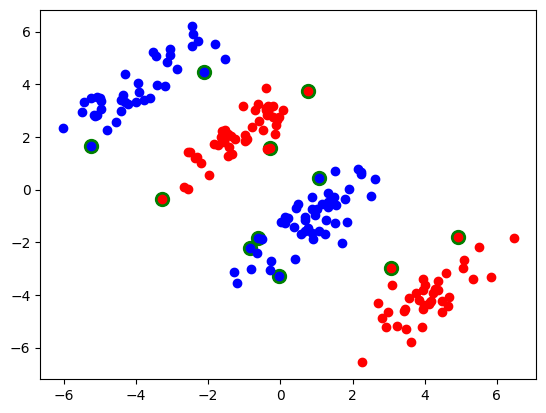

In [6]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.2193e+05 -1.3524e+08  4e+08  9e-01  9e-12
 1:  4.1656e+05 -3.9660e+07  6e+07  9e-02  3e-11
 2:  4.9785e+05 -7.8870e+06  1e+07  2e-02  7e-12
 3:  1.8606e+05 -1.3765e+06  2e+06  2e-03  4e-12
 4:  1.8085e+04 -2.7565e+05  3e+05  2e-04  3e-12
 5: -4.2560e+03 -1.8789e+04  1e+04  1e-12  3e-12
 6: -4.7208e+03 -9.5208e+03  5e+03  9e-13  4e-12
 7: -4.7994e+03 -9.3799e+03  5e+03  1e-12  3e-12
 8: -5.2147e+03 -7.5829e+03  2e+03  2e-12  3e-12
 9: -5.8706e+03 -7.7214e+03  2e+03  8e-13  4e-12
10: -6.2920e+03 -7.1152e+03  8e+02  5e-13  3e-12
11: -6.3241e+03 -7.0266e+03  7e+02  3e-14  4e-12
12: -6.6031e+03 -6.6575e+03  5e+01  2e-13  5e-12
13: -6.6276e+03 -6.6291e+03  1e+00  5e-13  5e-12
14: -6.6283e+03 -6.6283e+03  1e-02  5e-13  5e-12
15: -6.6283e+03 -6.6283e+03  1e-04  4e-13  5e-12
Optimal solution found.
10 support vectors out of 180 points
20 out of 20 predictions correct


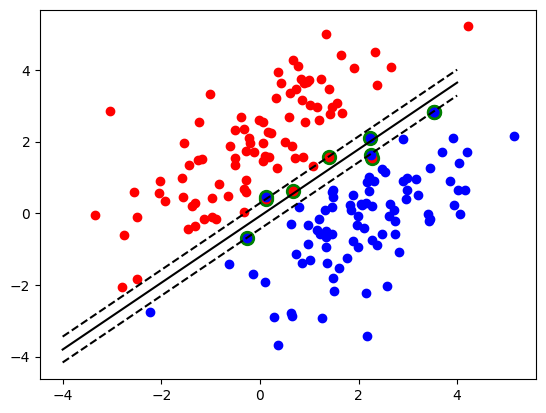

In [7]:
test_soft()

## Cách 2. Sử dụng thư viện sklearn  

### Data 

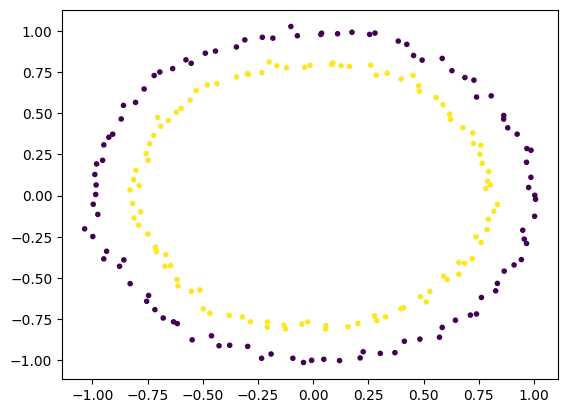

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm 
from matplotlib.backends.backend_pdf import PdfPages 
from sklearn.datasets import make_circles 
 
# Generate dataset and targets 
X, Y = make_circles(n_samples = 200, noise = 0.02) 
   
# visualizing data 
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.show()

### Sử dụng thư viện để phân loại và trực quan hóa kết quả

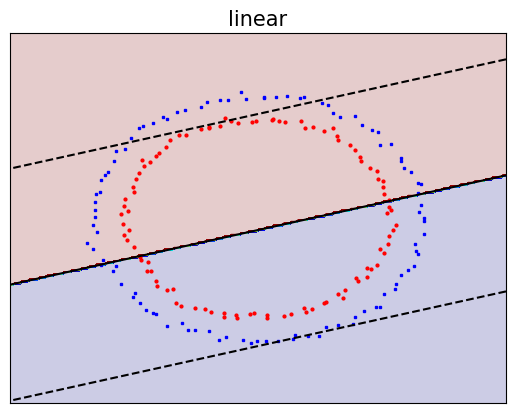

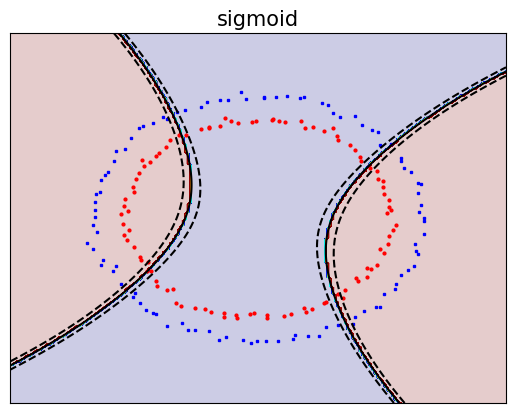

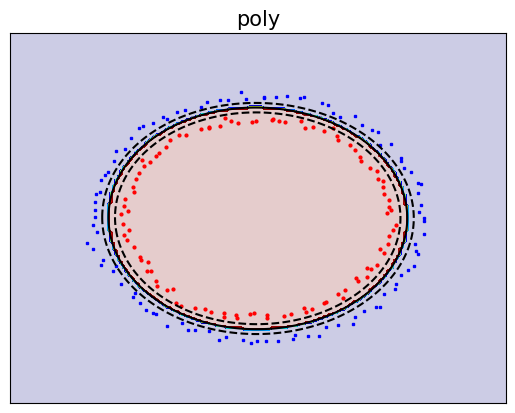

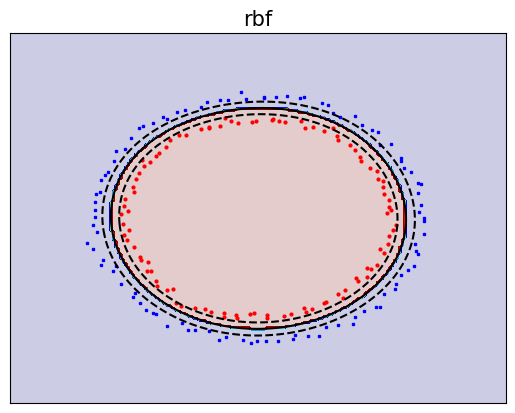

In [9]:
fignum = 1

# fit the model
for kernel in ("linear", "sigmoid", "poly", "rbf"):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0=1)
    clf.fit(X, Y)
    with PdfPages("output/output_of_" + kernel + ".pdf") as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=80,
            facecolors="None",
        )
        plt.plot(X[Y == 0, 0], X[Y == 0, 1], "bs", markersize=2)
        plt.plot(X[Y == 1, 0], X[Y == 1, 1], "ro", markersize=2)

        plt.axis("tight")
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap="jet", alpha=0.2)
        plt.contour(
            XX,
            YY,
            Z,
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
            levels=[-0.5, 0, 0.5],
        )
        plt.title(kernel, fontsize=15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
plt.show()

# Bài tập  
(Xác định Accuracy và Confusion Matrix cho mỗi phương pháp 'Build from Scratch' & 'Use library')  

## Test cho 3 model cách build from scratch (dữ liệu khác so với cách dùng thư viện ở dưới)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    cm = confusion_matrix(y_test, y_predict)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)


def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(kernel=gaussian_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    cm = confusion_matrix(y_test, y_predict)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)

def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    cm = confusion_matrix(y_test, y_predict)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)

if __name__ == "__main__":
    test_linear()
    test_non_linear()
    test_soft()


     pcost       dcost       gap    pres   dres
 0: -1.6969e+01 -3.3188e+01  6e+02  2e+01  2e+00
 1: -1.9954e+01 -1.7469e+01  2e+02  9e+00  8e-01
 2: -1.3448e+02 -8.6274e+01  2e+02  7e+00  6e-01
 3: -1.2915e+02 -6.5727e+01  2e+02  5e+00  5e-01
 4: -1.5312e+01 -1.3759e+01  4e+01  5e-01  4e-02
 5: -9.9893e+00 -1.1094e+01  1e+00  2e-04  2e-05
 6: -1.0758e+01 -1.0770e+01  1e-02  2e-06  2e-07
 7: -1.0767e+01 -1.0767e+01  1e-04  2e-08  2e-09
 8: -1.0767e+01 -1.0767e+01  1e-06  2e-10  2e-11
Optimal solution found.
3 support vectors out of 180 points
Accuracy: 1.0
Confusion Matrix:
 [[10  0]
 [ 0 10]]
     pcost       dcost       gap    pres   dres
 0: -5.6981e+01 -1.6798e+02  5e+02  2e+01  2e+00
 1: -8.7383e+01 -2.0917e+02  2e+02  8e+00  1e+00
 2: -1.3426e+02 -2.5802e+02  2e+02  4e+00  6e-01
 3: -2.6140e+02 -3.8787e+02  2e+02  3e+00  4e-01
 4: -3.4092e+02 -4.2849e+02  1e+02  1e+00  2e-01
 5: -3.7793e+02 -3.9345e+02  2e+01  3e-02  4e-03
 6: -3.8859e+02 -3.8932e+02  8e-01  1e-03  2e-04
 7: -3.8

## Test cho 4 model cách dùng thư viện (dữ liệu khác so vói cách build from scratch như trên)

Kernel: linear
Accuracy: 0.5
Confusion Matrix:
 [[47 53]
 [47 53]]
Kernel: sigmoid
Accuracy: 0.49
Confusion Matrix:
 [[48 52]
 [50 50]]
Kernel: poly
Accuracy: 1.0
Confusion Matrix:
 [[100   0]
 [  0 100]]
Kernel: rbf
Accuracy: 1.0
Confusion Matrix:
 [[100   0]
 [  0 100]]


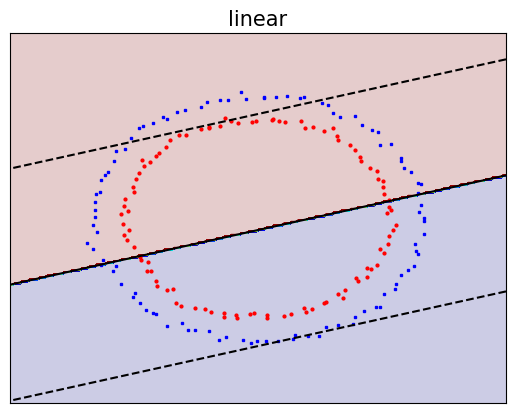

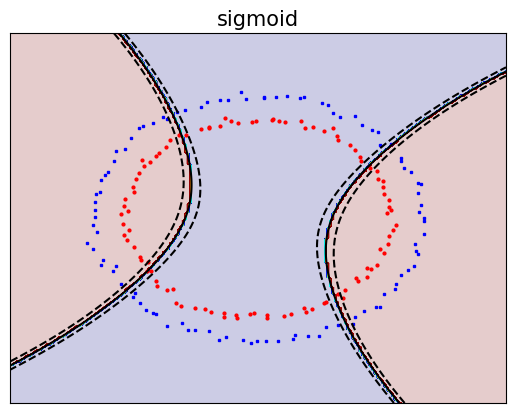

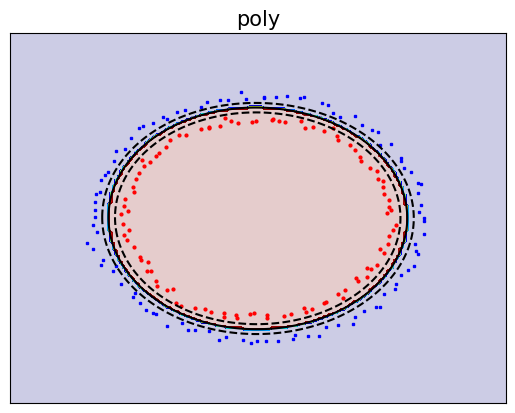

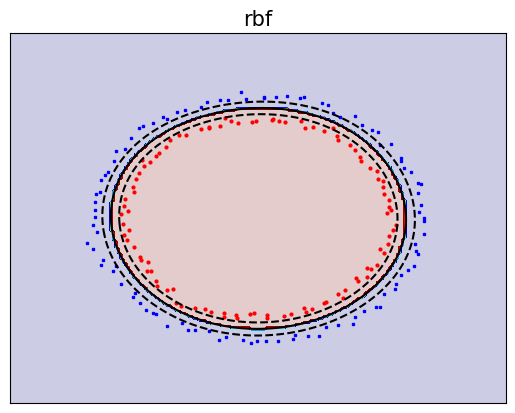

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

# # Generate random data
# np.random.seed(0)
# X = np.random.randn(300, 2)
# Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# # Change class labels to 0 and 1 instead of False and True
# Y = np.where(Y, 1, 0)

fignum = 1

# fit the model
for kernel in ("linear", "sigmoid", "poly", "rbf"):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0=1)
    clf.fit(X, Y)
    with PdfPages("output/output_of_" + kernel + "_ex1.pdf") as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=80,
            facecolors="None",
        )
        plt.plot(X[Y == 0, 0], X[Y == 0, 1], "bs", markersize=2)
        plt.plot(X[Y == 1, 0], X[Y == 1, 1], "ro", markersize=2)

        plt.axis("tight")
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap="jet", alpha=0.2)
        plt.contour(
            XX,
            YY,
            Z,
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
            levels=[-0.5, 0, 0.5],
        )
        plt.title(kernel, fontsize=15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())

        # Calculate accuracy and confusion matrix
        y_pred = clf.predict(X)
        acc = accuracy_score(Y, y_pred)
        cm = confusion_matrix(Y, y_pred)
        print(f"Kernel: {kernel}")
        print("Accuracy:", acc)
        print("Confusion Matrix:\n", cm)

        fignum = fignum + 1
        pdf.savefig()

plt.show()

Như vậy 2 kernel là poly và rbf cho kết quả ấn tượng với data có phân phối như này

# Ví dụ 2.  
(Dữ liệu kiểm tra chất lượng vi mạch từ 1 nhà máy sản xuất có đạt chuẩn khong qua tệp ex2data2.txt - X có 2 chiều và Y gồm 0 or 1)

## Đọc data và trực quan hóa data

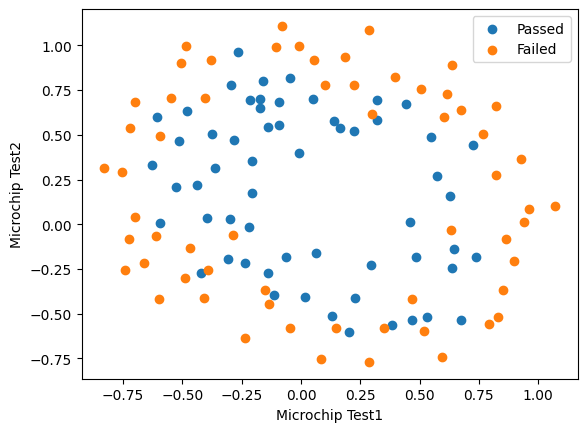

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages

# Đọc dữ liệu từ tệp txt
data = pd.read_csv('data/ex2data2.txt', header=None)
X = data.iloc[:, :-1]  # Features
Y = data.iloc[:, -1]   # Labels

# Visualizing data
mask = Y == 1
passed = plt.scatter(X[mask][0], X[mask][1])
failed = plt.scatter(X[~mask][0], X[~mask][1])
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

## Thực hiện SVM để phân loại

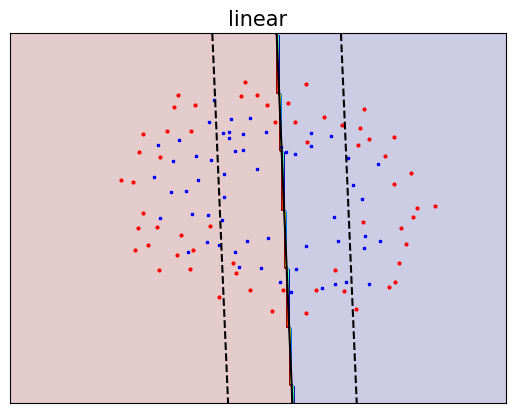

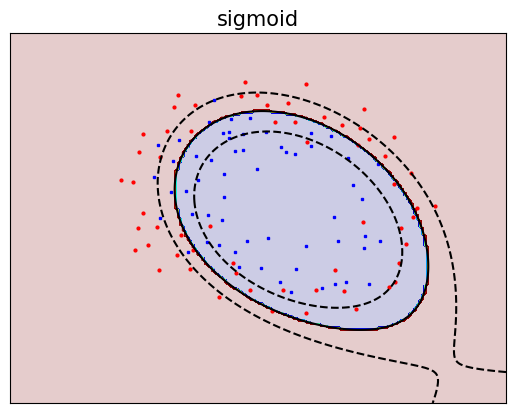

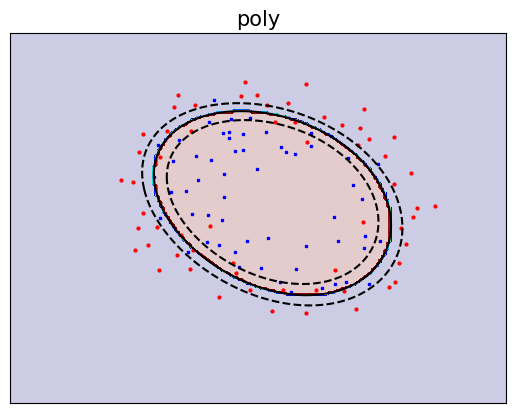

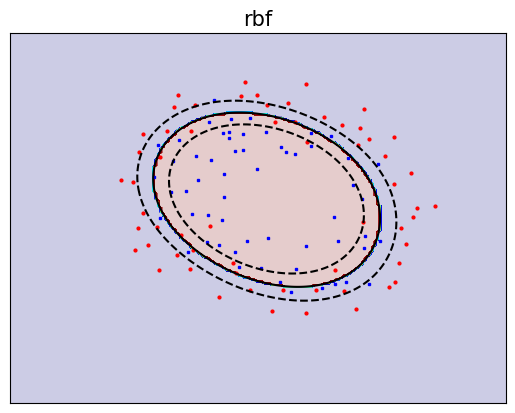

In [13]:
fignum = 1

# fit the model
for kernel in ("linear", "sigmoid", "poly", "rbf"):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0=1)
    clf.fit(X, Y)
    with PdfPages("output_of_" + kernel + "_ex2.pdf") as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=80,
            facecolors="None",
        )
        plt.plot(X[mask][0].values, X[mask][1].values, "bs", markersize=2)
        plt.plot(X[~mask][0].values, X[~mask][1].values, "ro", markersize=2)

        plt.axis("tight")
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap="jet", alpha=0.2)
        plt.contour(
            XX,
            YY,
            Z,
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
            levels=[-0.5, 0, 0.5],
        )
        plt.title(kernel, fontsize=15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
plt.show()

# Bài tập thực hành 1.  
(Dữ liệu ARgender.mat)

In [14]:
import scipy.io as sio 
from sklearn.svm import SVC 
 
A = sio.loadmat('data/ARgender.mat') 
X_train = A['Y_train'].T  
X_test = A['Y_test'].T  
print(X_train.shape) 
N = 700 
y_train = A['label_train'].reshape(N) 
y_test = A['label_test'].reshape(N)

(700, 300)


In [15]:
# List of kernels
kernels = ["linear", "sigmoid", "poly", "rbf"]

best_kernel = None
best_accuracy = 0

# Iterate over each kernel
for kernel in kernels:
    # Train SVM model
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print accuracy for the current kernel
    print(f"Accuracy for {kernel} kernel: {accuracy}")

    # Update best kernel if current kernel gives better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel

print(f"\nBest kernel: {best_kernel} with accuracy: {best_accuracy}")

Accuracy for linear kernel: 0.9028571428571428
Accuracy for sigmoid kernel: 0.9
Accuracy for poly kernel: 0.9114285714285715
Accuracy for rbf kernel: 0.9085714285714286

Best kernel: poly with accuracy: 0.9114285714285715


# Bài tập thực hành 2.  
(Dữ liệu dataset.csv)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv("data/dataset.csv")
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)

# Chuyển vị ma trận dữ liệu do ta đọc bằng Pandas => mỗi record là 1 dong
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

In [17]:
# List of kernels
kernels = ['linear', 'sigmoid', 'poly', 'rbf']

best_kernel = None
best_accuracy = 0

# Iterate over each kernel
for kernel in kernels:
    # Train SVM model
    clf = SVC(kernel=kernel)
    clf.fit(XTrain, yTrain)
    
    # Predict on test set
    yPred = clf.predict(XTest)
    
    # Calculate accuracy
    accuracy = accuracy_score(yTest, yPred)
    
    # Print accuracy for the current kernel
    print(f'Accuracy for {kernel} kernel: {accuracy}')
    
    # Update best kernel if current kernel gives better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel

print(f'\nBest kernel: {best_kernel} with accuracy: {best_accuracy}')

Accuracy for linear kernel: 0.9
Accuracy for sigmoid kernel: 0.74
Accuracy for poly kernel: 0.86
Accuracy for rbf kernel: 0.93

Best kernel: rbf with accuracy: 0.93


# Bài tập thực hành 3.  
(Dữ liệu ung thư vú)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

# Breast cancer dataset for classification
data = load_breast_cancer()
print(data.feature_names)
print(data.target_names)
print(data.feature_names.shape, data.target_names.shape)

X = data.data 
y = data.target
print(X.shape, y.shape)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']
(30,) (2,)
(569, 30) (569,)


Thực hiện chuyển đổi nhãn đầu ra từ chuỗi sang số

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Chuyển đổi nhãn đầu ra từ dạng chuỗi thành dạng số nguyên
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


Phân chia data và chuẩn hóa

In [29]:
# Split data into train and test sets 
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)

# Feature scaling 
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

Thực hiện tìm kernel SVM cho kết quả tốt nhất

In [30]:
# List of kernels
kernels = ["linear", "sigmoid", "poly", "rbf"]

best_kernel = None
best_accuracy = 0

# Iterate over each kernel
for kernel in kernels:
    # Train SVM model
    clf = SVC(kernel=kernel)
    clf.fit(XTrain, yTrain)

    # Predict on test set
    yPred = clf.predict(XTest)

    # Calculate accuracy
    accuracy = accuracy_score(yTest, yPred)

    # Print accuracy for the current kernel
    print(f"Accuracy for {kernel} kernel: {accuracy}")

    # Update best kernel if current kernel gives better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel

print(f"\nBest kernel: {best_kernel} with accuracy: {best_accuracy}")

Accuracy for linear kernel: 0.972027972027972
Accuracy for sigmoid kernel: 0.951048951048951
Accuracy for poly kernel: 0.916083916083916
Accuracy for rbf kernel: 0.965034965034965

Best kernel: linear with accuracy: 0.972027972027972
